# Homework 6: Bootstrapping to estimate parameter ranges of nonlinear models

***
### Academic honesty statement

**SANTIAGO ORTIZ LAVERDE**

- I state that I worked alone on this assignment. Therefore, I take full responsibility for the academic integrity of the work presented below.
***

## Part 3 Analyze fit results

### 1.1 First task
- One a single figure, plot the model's response vs time for all 200 estimates of the parameter values. 

In [1]:
using CSV, DataFrames
using BenchmarkTools

dat = CSV.read("Homework 6 Data.csv", DataFrame);
t = dat[!, :Time]
exp1 = dat[!, :Exp1]
exp2 = dat[!, :Exp2]
exp3 = dat[!, :Exp3]
exp4 = dat[!, :Exp4]
exp5 = dat[!, :Exp5]
data_origin = reduce(hcat, [t, exp1, exp2, exp3, exp4, exp5]);

ts = size(data_origin)[1]
Exps = size(data_origin)[2] - 1
N_Cbact = ts*Exps
N_time = copy(N_Cbact);

function fill_array(short; N=N_time, js=ts, ls=Exps)
    long = Array{Float64, 2}(undef, N, 1)
    for j in range(1, js)
        f = (j-1)*ls
        long[1+f:ls+f] = short[j]*ones(ls)
    end
    long
end

function bootstrap(data; N=N_Cbact, js=ts, ls=Exps)
    Ytraining = Array{Float64, 2}(undef, N, 1)
    for j in range(1, js)
        f = (j-1)*ls
        Ytraining[1+f:ls+f] = rand(data[j, 2:end], (1, ls))
    end
    Ytraining
end;

In [2]:
using DifferentialEquations, Statistics, Optim

function bacterial_model!(du, u, p, t)
    a, b = p
    y = u[1]
    du[1] = dydt = y^3/(a + y^3) - b*y
end;

u0 = [mean(data_origin[1, 2:end])]
tspan = (10.0, 50.0)
p = [0.3, 0.8]
prob = ODEProblem(bacterial_model!, u0, tspan, p);

In [3]:
function RMSE(p, training_data; prob=prob, t=t)
    prob = remake(prob; u0=[mean(training_data[1:Exps])], p=p)
    ODE_output = convert(Array, solve(prob, Tsit5(), saveat=t))
    err = training_data .- fill_array(ODE_output; N=N_Cbact)
    sqrt(sum(err.^2))
end;

function Bootstrapping(data, guess; prob=prob, iter=200, t_eval=range(10, 50, 200),
                                    lower=fill(0.0, 2), upper=fill(1.0, 2))
    SAmIn = SAMIN(rt=0.1, verbosity=0)
    options = Optim.Options(iterations=10^6)
    estimations = Array{Float64, 2}(undef, iter, length(guess)+1)
    solutions = Array{Float64, 2}(undef, iter, length(t_eval))
    for i in range(1, iter)
        training_data = bootstrap(data)
        f(p) = RMSE(p, training_data)
        res = Optim.optimize(f, lower, upper, guess, SAmIn, options)
        estimations[i, 1] = Optim.minimum(res)
        estimations[i, 2:end] = guess = Optim.minimizer(res)
        prob = remake(prob; u0=[mean(training_data[1:Exps])], p=guess)
        solutions[i, 1:end] = convert(Array, solve(prob, Tsit5(), saveat=t_eval))
    end
    Dict("Optim_estimations" => estimations, "ODE_solutions" => solutions)
end;
    
BS_dict = Bootstrapping(data_origin, iter=250, [0.3, 0.8]; lower=[-1000, 0.0], upper=[1000, 1.0]);    

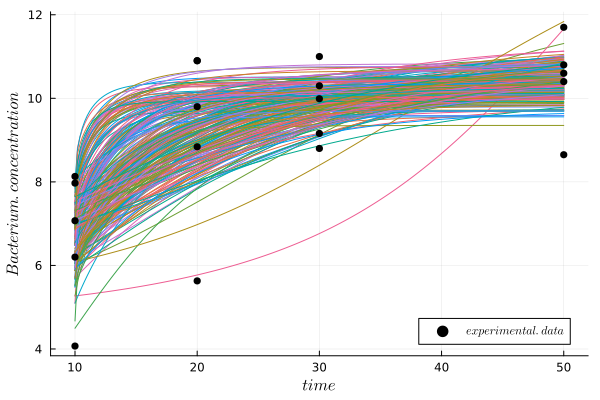

In [4]:
using Plots, LaTeXStrings

Cbact = Array{Float64, 2}(undef, N_Cbact, 1)
for j in range(1, ts)
    f = (j-1)*Exps
    Cbact[1+f:Exps+f] = data_origin[j, 2:end]
end

t_eval=range(10, 50, 200)
estms = size(BS_dict["Optim_estimations"])[1]
model_outputs = plot(xlabel=L"time", ylabel=L"Bacterium.concentration")
for i in range(1, estms)
    plot!(model_outputs, t_eval, BS_dict["ODE_solutions"][i, :], label=false)
end

plot!(fill_array(t), Cbact, color=:black, seriestype=:scatter, label=L"experimental.data")
plot!(xlims=(8, 52), legend=:bottomright)

### 1.2 Second task

- Are the fits reasonable? Should any of the fits be discounted? Why so?

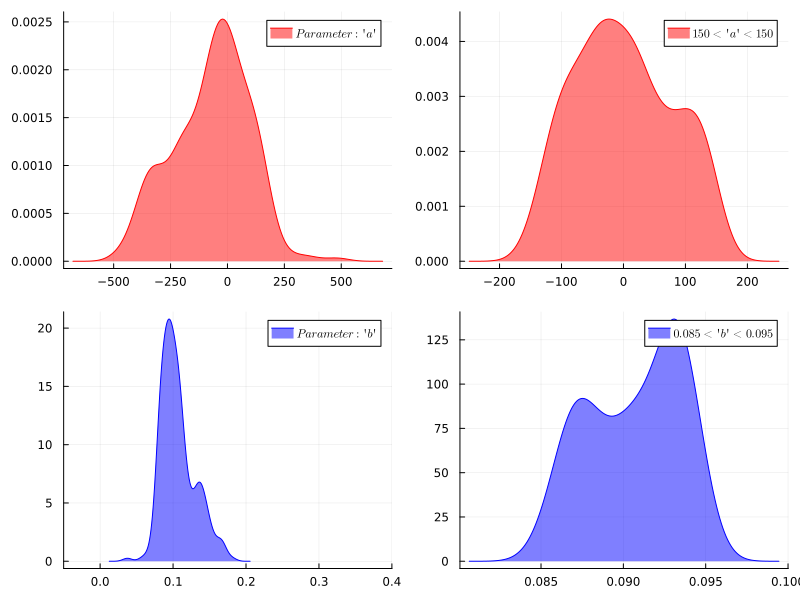

In [5]:
using StatsPlots, LaTeXStrings

condition_range(dist, ll, lu) = dist.>ll .&& dist.<=lu

a_dist = BS_dict["Optim_estimations"][:, 2];
b_dist = BS_dict["Optim_estimations"][:, 3];

a_narrowed = condition_range(a_dist, -150, 150)
a_reduced = a_dist[a_narrowed]
b_narrowed = condition_range(b_dist, 0.085, 0.095)
b_reduced = b_dist[b_narrowed]

a_dens = density(a_dist, color=:red, fill=(0, .5, :red), label=L"Parameter: 'a'")
b_dens = density(b_dist, color=:blue, fill=(0, .5, :blue), label=L"Parameter: 'b'", xlims=(-0.05, 0.4))
ar_dens = density(a_reduced, color=:red, fill=(0, .5, :red), label=L"150<'a'<150")
br_dens = density(b_reduced, color=:blue, fill=(0, .5, :blue), label=L"0.085<'b'<0.095")
plot(a_dens, ar_dens, b_dens, br_dens, layout=(2, 2), size=(800, 600))

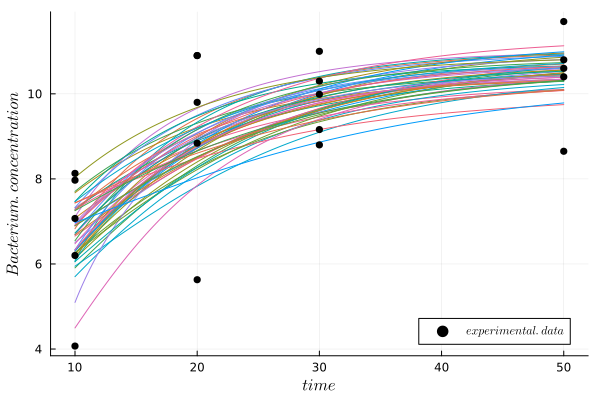

In [6]:
merged_condition = a_narrowed .&& b_narrowed
best_fits = BS_dict["ODE_solutions"][merged_condition, :]

model_outputs = plot(xlabel=L"time", ylabel=L"Bacterium.concentration")
for i in range(1, sum(merged_condition))
    plot!(model_outputs, t_eval, best_fits[i, :], label=false)
end
plot!(fill_array(t), Cbact, color=:black, seriestype=:scatter, label=L"experimental.data")
plot!(xlims=(8, 52), legend=:bottomright)

<div class="alert alert-block alert-info">
<b>Comments: Although the fit is always within the confidence range provided by the original experimental data (as expected), some fits are off the path of most curves. In order to filter out some of these responses, a confidence range is set for each parameter according to their density curve. In this way, outliers are eliminated.</b>.
</div>